#### This code block's main purpose is visual inspection. By looking at the images the model flagged as outliers, you can gain valuable insights:

#### Are they corrupted or noisy images?

#### Are they mislabeled?

#### Do they belong to a rare or unusual class?

#### This analysis helps you validate your outlier detection process 

In [10]:
import os
import pathlib
import numpy as np
from PIL import Image, ImageOps
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression


#Load the dataset
data_dir = r"./iris-dataset/"                             
data_dir = pathlib.Path(data_dir)
setosa = list(data_dir.glob('iris-setosa/*'))
versicolour = list(data_dir.glob('iris-versicolour/*'))
virginica = list(data_dir.glob('iris-virginica/*'))

print("No. of samples of setosa: ", len(setosa))
print("No. of samples of versicolour: ", len(versicolour))
print("No. of samples of virginica: ", len(virginica))

df_images = {
    'setosa' : setosa,
    'versicolour' : versicolour,
    'virginica': virginica
}

# numerical/integer labels for the categories
df_labels = {
    'setosa' : 0,
    'versicolour' : 1,
    'virginica': 2
}

No. of samples of setosa:  67
No. of samples of versicolour:  75
No. of samples of virginica:  85


In [11]:
#Apply pre-processing to all the images and prepare the dataset
X, y = [], []                                             # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = Image.open(str(image))
        resized_img = img.resize((128, 128))               
        gray_img= ImageOps.grayscale(resized_img)
        new_img = asarray(gray_img)
        new_img = new_img.astype('float32')
        new_img /= 255.0
        mean = new_img.mean()
        new_img = new_img - mean
        mean, std = new_img.mean(), new_img.std()
        new_img = (new_img - mean) / std
        X.append(new_img) 
        y.append(df_labels[label])
X=np.array(X)
y=np.array(y)
print("Images: ", X.shape)
print("Labels:", y.shape)

Images:  (227, 128, 128)
Labels: (227,)


In [12]:
#Prepare training and testing dataset to develop the classifier

X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, train_size = 0.8, random_state=42)    # 80% : training, 20%: testing
print("Number of train samples:", X_tr.shape)
print("Number of test samples:", X_te.shape)



Number of train samples: (181, 128, 128)
Number of test samples: (46, 128, 128)


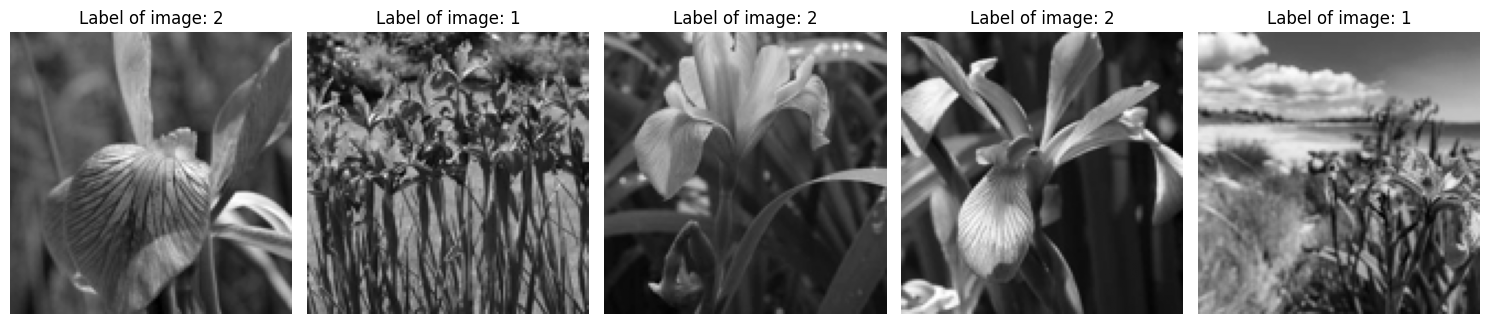

In [13]:
plt.figure(figsize=(15,5))

for i in range(1,6):
 plt.subplot(1,5,i)
 plt.imshow(X_tr[i,:,:],cmap='gray')
 plt.title('Label of image: {}'.format(Y_tr[i]))
 plt.axis('off')
 plt.tight_layout()
plt.show()

In [14]:
# Use the pixel values as features
X_train=X_tr.reshape(X_tr.shape[0],128*128)
X_test=X_te.reshape(X_te.shape[0],128*128)
print("Train data:", X_train.shape)
print("Test data: ", X_test.shape)

# identify outliers in the training dataset
# Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.
# It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.
# takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances.

iso = IsolationForest(contamination=0.1, random_state=42)
#contamination” argument is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
print(mask)
X_train_, Y_train_ = X_train[mask, :], Y_tr[mask]
print("Train data:", X_train_.shape)

Train data: (181, 16384)
Test data:  (46, 16384)
[ True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True  True  True False  True  True False  True  True
  True  True  True  True False  True False  True  True  True  True  True
  True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  

[  2  13  55  59  65  74  84  88  99 110 114 117 124 126 133 138 159 176]


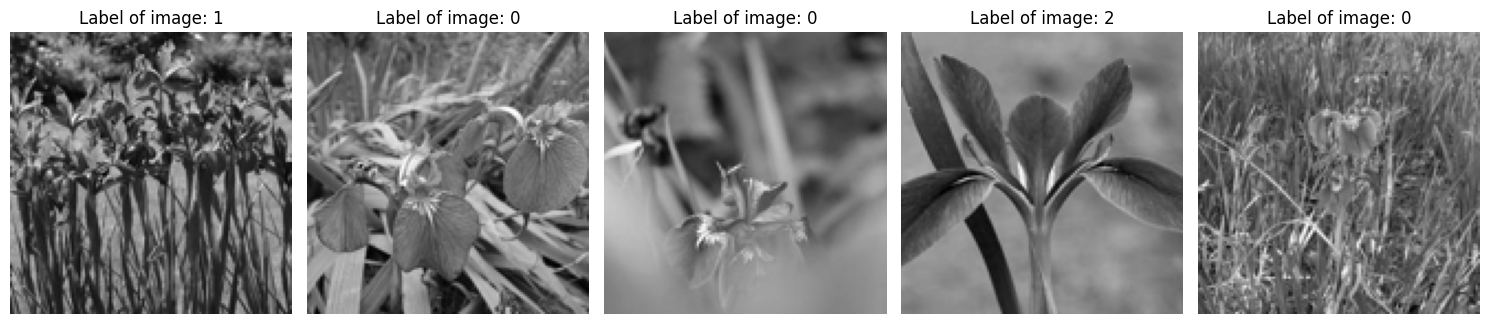

In [15]:
indices=np.where(mask==False)[0]
print(indices)
plt.figure(figsize=(15,5))
j=0
for i in range(1,6):
 plt.subplot(1,5,i)
 plt.imshow(X_tr[indices[j],:,:],cmap='gray')
 plt.title('Label of image: {}'.format(Y_tr[indices[j]]))
 plt.axis('off')
 plt.tight_layout()
 j=j+1
plt.show()

In [16]:
logreg =  LogisticRegression()
logreg.fit(X_train,Y_tr)

score = logreg.score(X_test, Y_te)
print(score)

0.3695652173913043
